In [48]:
import numpy as np
import scipy as sp
import scipy.special
import climpy.utils.wrf_chem_utils as wrf_chem
import matplotlib.pyplot as plt

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

## Intro

This example illustrates the contribution of the aerosols log normal size distribution to the PM of arbitrary size.
Specific example was designed for the MADE implementation in WRF-Chem, which has 3 modes.

In [92]:
# to get the size distribution parameters from WRF-Chem you should normally use this:
# sg_list, dg_list, moment0_list, moment3_list = aqaba.get_wrf_sd_params(nc)
# But to keep example simple and keep ad idea on the range of value, I've tabulated the typical values below

sg_list = [1.7, 2.0, 2.5]
dg_list = [2.15e-8, 2.65e-8, 4.29e-7]
# Last value 1.5e5 was adjusted from 1.5e8 to make all 3 modes equally contribute to volume/mass
moment0_list = [50e8, 12e8, 1.5e5]
#moment0_list = [50e8, 12e8, 1.5e8]
# We don't need next raw in this example, but you will need it in WRF-Chem case to derive dg
moment3_list = [177e-15, 1865e-15, 530e-12]

# pick the grid for diameter/radius
dp = np.logspace(-9, -4, 100)
radii = dp / 2
# sample the distributions
dNdlogp_list = wrf_chem.sample_WRF_MADE_size_distributions(dp, sg_list, dg_list, moment3_list, moment0_list)
# compute 3rd moment/volume
dVdlogp_list = []
for dNdlogp in dNdlogp_list:
     dVdlogp = dNdlogp * 4 / 3 * np.pi * (radii*10**-6) ** 3
     dVdlogp_list.append(dVdlogp)

dNdlogp_vo = {}
dNdlogp_vo['data'] = dNdlogp_list
dNdlogp_vo['radii'] = radii * 10**6  # um

vo = {}
vo['data'] = dVdlogp_list
vo['radii'] = radii * 10**6  # um

Strictly speaking analytical distribution spans values from $-\infty$ to $+\infty$.

Text(0, 0.5, 'dV/dlogr, ($\\mu m^3/cm^3$)')

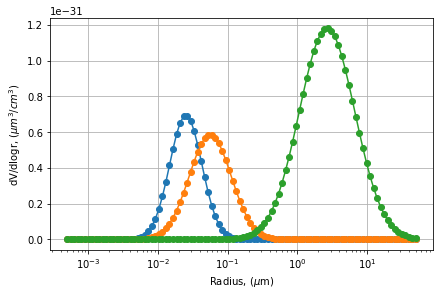

In [93]:
fig = plt.figure(constrained_layout=True)#, figsize=(get_full_screen_page_width_inches()/2, 9.85416667), dpi=MY_DPI)
plt.grid()
plt.plot(vo['radii'], vo['data'][0], '-o')#, color='orange')
plt.plot(vo['radii'], vo['data'][1], '-o')#, color='orange')
plt.plot(vo['radii'], vo['data'][2], '-o')#, color='orange')

plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1 * 10 ** -2, 5 * 10 ** 1])
plt.xlabel('Radius, ($\mu $m)')
plt.ylabel('dV/dlogr, ($\mu m^3/cm^3$)')

X axis scale is log and thus area under the curve shows the contribution to the volume.
Atmospheric science often deals with the quantities such as PM10, which are particles up to 10 um in diameters.
To get the modes contribution to specific size PM, we need to integrate bounded size distribution.

Of course the integration can be done numerically, which can be slow.
For the log-normal pdfs there is analytical solution given through the error function.
This approach is much faster and allows simple use of the additional factor.
See for details https://patarnott.com/pdf/SizeDistributions.pdf, equations 24-27

In [94]:
# define the range of sizes, in this case 250 nm -1 micron.
d_min = 0.25 * 10**-6  # m
d_max = 1 * 10**-6  # um

#d_min = 4 * 10**-6  # m
#d_max = 100 * 10**-6  # um
#d_min = 3 * 10**-8  # m

#d_min = 1 * 10**-7  # m
#d_max = 10 * 10**-6  # um

# this factors are the ratio that they contribute to the total number N_0 or volume V_0
N_factors = []
V_factors = []
for sg, dg, moment3, moment0 in zip(sg_list, dg_list, moment3_list, moment0_list):    
    d_v_median = dg * np.exp(3 * np.log(sg)**2)  # volume median diameter

    #print(sp.special.erf(np.log(d_max/dg)/(2**0.5*np.log(sg))))
    print(d_min)    
    print(dg)
    print(d_min/dg)
    print(np.log(d_max/dg)/(2**0.5*np.log(sg)))
    print(2**0.5*np.log(sg))
    print((2**0.5)*np.log(sg))
    
    # N[Dmin, Dmax] = N_0/2 * []
    N_factor = 1/2 * (sp.special.erf(np.log(d_max/dg)/(2**0.5*np.log(sg))) - sp.special.erf(np.log(d_min/dg)/(2**0.5*np.log(sg))))    
    # V[Dmin, Dmax] = N_0/2 * []   ! Still N_0, not V_0, express N_0 through V_0
    # V_0 = N_0  * pi/6 * dg^3 * exp(9/2 ln(sg)^2)
    NtoV_factor = (np.pi/6 * dg**3 * np.exp(9/2*np.log(sg)**2))**-1
    #print(NtoV_factor)
    V_factor = 1/2 * (sp.special.erf(np.log(d_max/d_v_median)/(2**0.5*np.log(sg))) - sp.special.erf(np.log(d_min/d_v_median)/(2**0.5*np.log(sg))))
    #print(V_factor)
    
    #print(N_factor)
    

    N_factors.append(N_factor)
    V_factors.append(V_factor)
print(N_factors)
print(V_factors)

2.5e-07
2.15e-08
11.627906976744185
5.116726370370092
0.7504216692304371
0.7504216692304371
2.5e-07
2.65e-08
9.433962264150944
3.703729033194666
0.9802581434685472
0.9802581434685472
2.5e-07
4.29e-07
0.5827505827505828
0.6530932688550987
1.2958307800931994
1.2958307800931994
[1.8857660151749833e-06, 0.0006020601510289825, 0.5443356184503549]
[0.0012158705239486145, 0.12255274596001153, 0.033559374840372136]


Text(0, 0.5, 'dN/dlogr, (#$/cm^3$)')

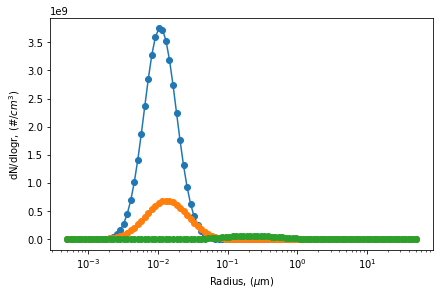

In [91]:
fig = plt.figure(constrained_layout=True)#, figsize=(get_full_screen_page_width_inches()/2, 9.85416667), dpi=MY_DPI)
plt.cla()
plt.plot(dNdlogp_vo['radii'], dNdlogp_vo['data'][0], '-o')#, color='orange')
plt.plot(dNdlogp_vo['radii'], dNdlogp_vo['data'][1], '-o')#, color='orange')
plt.plot(dNdlogp_vo['radii'], dNdlogp_vo['data'][2], '-o')#, color='orange')

plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1 * 10 ** -2, 5 * 10 ** 1])
plt.xlabel('Radius, ($\mu $m)')
plt.ylabel('dN/dlogr, (#$/cm^3$)')